# Lecture 7: Now for Real MCMC
AM207: Verena Kaynig-Fittkau,and Pavlos Protopapas, Harvard University


In [46]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')

# Rainy Sunny Reprise
Remember our rainy sunny example from the previous lecture. We have two states connected each to itself and to each other. To simplify things we will now just set all transition probabilities to 0.5.

The transition matrix
[[ 0.3  0.7]
 [ 0.5  0.5]]
Stationary distribution
[[ 0.41666673  0.58333327]
 [ 0.41666662  0.58333338]]


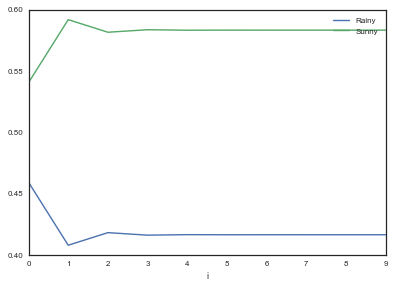

In [49]:
# the transition matrix for our chain
#transition_matrix = np.array([[0.5, 0.5],[0.5, 0.5]])
transition_matrix = np.array([[0.3, 0.7],[0.5, 0.5]])

print "The transition matrix"
print transition_matrix

print "Stationary distribution"
print np.linalg.matrix_power(transition_matrix,10)

# initial state 
p = np.random.uniform(low=0,high=1, size=2)
# normalize 
p = p/np.sum(p)

# do 100 iterations
q=np.zeros((10,2))
for i in np.arange(0,10):
    #compute probability for each state
    q[i, :] = np.dot(p,np.linalg.matrix_power(transition_matrix,i))

plt.plot(q)
plt.xlabel('i')
plt.legend( ('Rainy', 'Sunny'))

So the stationary distribution of our Markov Chain is [0.5, 0.5]. We can do the same by sampling from our chain. We will modify this sampling to model any stationary distribution we want! The example below only works for the symmetric proposal transition matrix. For more flexibility read further below!

0.238111111111 0.761888888889


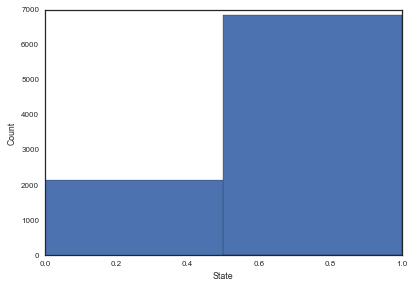

In [50]:
desired_stationary_distribution = [0.3, 0.7]

number_of_samples = 10000
samples = np.zeros(number_of_samples)

oldPosition = np.random.randint(low=0, high=2)
samples[0] = oldPosition

for i in xrange(number_of_samples-1):
    newPosition = np.random.choice(2,p=transition_matrix[oldPosition])
    
    newProb = desired_stationary_distribution[newPosition]
    oldProb = desired_stationary_distribution[oldPosition] 
    acceptance_probability = newProb / oldProb
    if np.random.uniform() < acceptance_probability:
        # accept 
        samples[i+1] = newPosition
        oldPosition = newPosition
    else:
        samples[i+1] = oldPosition
    
samples = samples[1000:]    
print 1-np.mean(samples), np.mean(samples)    
samples_hist = plt.hist(samples, bins=2)
plt.xlabel("State")
plt.ylabel("Count")

Here is how to correct for the asymmetric transition probability matrix of the original Markov Chain

0.298888888889 0.701111111111


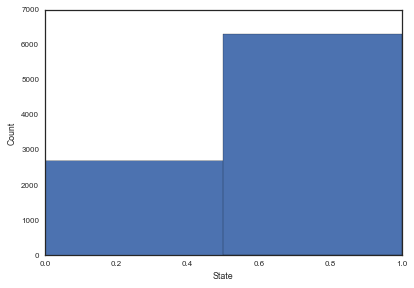

In [51]:
desired_stationary_distribution = [0.3, 0.7]

number_of_samples = 10000
samples = np.zeros(number_of_samples)

oldPosition = np.random.randint(low=0, high=2)
samples[0] = oldPosition

for i in xrange(number_of_samples-1):
    newPosition = np.random.choice(2,p=transition_matrix[oldPosition])
    
    newProb = desired_stationary_distribution[newPosition] * transition_matrix[newPosition, oldPosition]
    oldProb = desired_stationary_distribution[oldPosition] * transition_matrix[oldPosition, newPosition]

    acceptance_probability = newProb / oldProb
    if np.random.uniform() < acceptance_probability:
        # accept 
        samples[i+1] = newPosition
        oldPosition = newPosition
    else:
        samples[i+1] = oldPosition
    
samples = samples[1000:]    
print 1-np.mean(samples), np.mean(samples)    
samples_hist = plt.hist(samples, bins=2)
plt.xlabel("State")
plt.ylabel("Count")

# Markov Chain Sampling
In this example we sample from $p(x) =6x(1-x)$ using the Metropolis algorithm with proposal 
distribution 

$$x^* \sim N(x, 0.6) $$

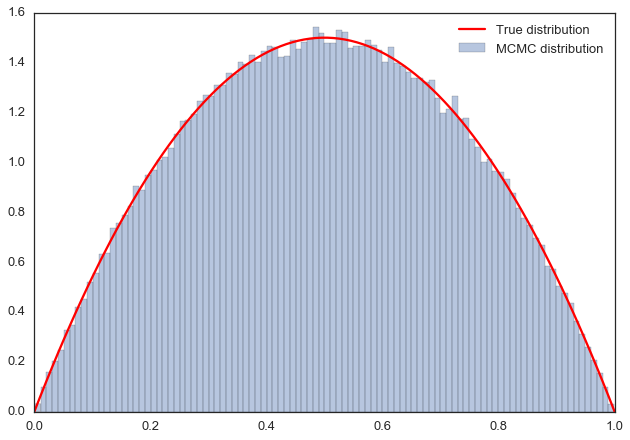

starting point was  0.154623608263


In [5]:
## FUNCTIONS 
# target distribution p(x) 
p = lambda x: 6*x*(1-x)

# number of samples
n = 1000000

# sigma for our proposal distribution
# corresponds to step size
sig = 0.6

#intitialize the sampling. Start somewhere from 0..1
x0 = np.random.uniform()
#x0 = 0.00000001

x_prev = x0

x = [] # to save our samples

for i in xrange(n):
    # sample new state candidate from proposal distribution
    x_star = np.random.normal(x_prev, sig)

    #while  (x_star <0) | (x_star > 1):  # make sure you stay within bounds
    #    x_star = np.random.normal(x_prev, sig)
       
    P_star = p(x_star)
    P_prev = p(x_prev)
    
    U =  np.random.uniform()
    
    # A is simple because our transition probability is symmetric (Metropolis only)
    A =  P_star/P_prev # did we go up or down? 
       
    if U < A: #coin flip to see if we accept
        x_prev = x_star 

    x.append(x_prev) # we always get a sample question just is if we stay or move on

# plot our sample histogram
plt.hist(x,100, alpha=0.4, label=u'MCMC distribution', normed=True) 

#plot the true function
xx= np.linspace(0,1,100)
plt.plot(xx, p(xx), 'r', label=u'True distribution') 
plt.legend()

plt.show()
print "starting point was ", x0

Note: The part where we rejected new proposals if they fell outside the desired range made our sampling wrong. What is basically happening is that we are then sampling from a truncated proposal, and this truncated proposal is not normalized. Normalizing against this actually made the computation much slower, so in this case I would just comment those lines out. The function is negative anyways if we try to go out of the defined bounds, so it all works out for this example.
If you want to read in more detail about this, please look at this [blog post](https://darrenjw.wordpress.com/2012/06/04/metropolis-hastings-mcmc-when-the-proposal-and-target-have-differing-support/) from Darren Wilkinson.

# Bioassay experiment

We demonstrate this with an example and examine the convergence of the resulting samples. 

Bioassay (commonly used shorthand for biological assay), or biological standardisation is a type of scientific experiment. Bioassays are typically conducted to measure the effects of a substance on a living organism and are essential in the development of new drugs and in monitoring environmental pollutants. Both are procedures by which the potency (pharmacology) or the nature of a substance is estimated by studying its effects on living matter.

In this experiment 5 animals were tested for various doses and the number of deaths were recorded. The  death rate is usually modeled as logit$^{-1}$ with two parameters (see below). The goal is to estimate those parameters and be able to infer death rates as a function of dose. 

In [29]:
n=5
X=np.array([-0.86,-0.30,-0.05,0.73])
Y=np.array([0,1,3,5])

The likelihood since is a success/fail experiment is expressed as a Binomial:

$$ P(D_i|\theta_i) = p(y_i, n_i| \theta_i) = {\rm Bionomial}( y_i, n_i \vert \theta_i)  \,\,\,\,    \rm{for}\,\, i=1, \ldots, 4$$

where $\theta$ is the rate of deaths which is modeled as a $\rm{logit}^{-1}$:  

$$ \theta_i = {\rm logit}^{-1}(\alpha+\beta x_i) \,\,\,\, \rm{for} \,\, i=1, \ldots, 4$$

We use flat priors for $\alpha,\beta$: 

$$ p(\alpha, \beta) \propto 1 $$

Posterior: 

$$ p(\alpha, \beta \vert y) \propto p(\alpha, \beta) \prod_{i=1}^{k} p(y_i \vert \alpha, \beta, n_i, x_i) $$
$$ = 1 \prod_{i=1}^{k} [{\rm logit}^{-1}(\alpha+\beta x_i)]^{y_i} [ 1-{\rm logit}^{-1}(\alpha+\beta x_i)]^{n_i-y_i} $$



In [30]:
## invLogit this is the same as a sigmoid
logitInv= lambda x: np.exp(x)/(1.0+np.exp(x))

## posterior
def calc_posterior(a, b, y=Y, x=X):
    # Calculate joint posterior, given values for a, b 
    # x: dosage
    # y: number of deaths
    # a + b: parameters of the model
    p = np.product((logitInv(a+b*x)**y)*(1.0-logitInv( a+b*x))**(n-y))
    
    return p

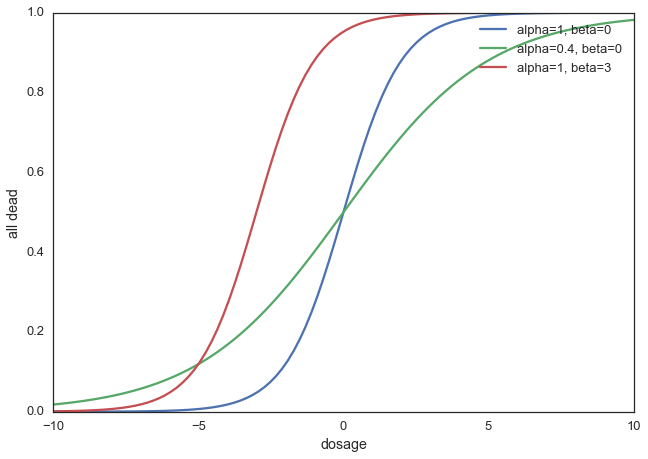

In [45]:
xx = np.linspace(-10,10,100)
plt.plot(xx, logitInv(xx), label="alpha=1, beta=0")
plt.plot(xx, logitInv(0.4*xx), label="alpha=0.4, beta=0")
plt.plot(xx, logitInv(xx+3), label="alpha=1, beta=3")
plt.xlabel("dosage")
plt.ylabel("all dead")
plt.legend()


In [20]:
# check my posterior. I do a brute force just to make sure I do the right thing
X1 = np.linspace(-3,7,101) # alpha
X2 = np.linspace(-10, 30,100) # beta
k=0;j=0
pp=np.zeros((101,100))
for x1 in X1:
    j=0
    for x2 in X2:
        pp[k,j]=calc_posterior(x1,x2)
        j +=1
    k +=1
    


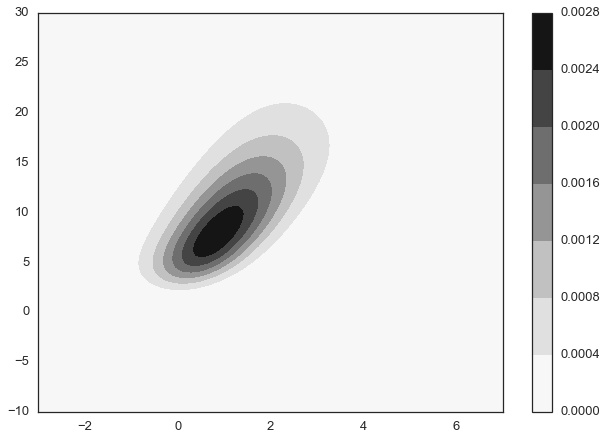

In [21]:
# look at the posterior distribution
plt.contourf(X1,X2,pp.T)
plt.colorbar()

In [22]:
rnorm = np.random.normal
runif = np.random.rand

def metropolis(n_iterations, initial_values, prop_std=[1,1], doPrint=True):
    #################################################################
    # function to sample using Metropolis 
    # (assumes proposal distribution is symmetric)
    # 
    # n_iterations:  number of iterations
    # initial_values: multidimensional start position for our chain
    # prop_std: standard deviation for Gaussian proposal distribution 
    ##################################################################
    
    
    #np.random.seed(seed=1)
    n_params = len(initial_values)
            
    # Initial proposal standard deviations
    # generates a list of length n_params
    #prop_sd = [prop_std]*n_params
    prop_sd = prop_std
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values
    # the * assigns the arguments of the function according to the list elements
    current_prob = calc_posterior(*trace[0])
    
    # Initialize acceptance counts
    # We can use this to tune our step size
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%10000 and doPrint: 
            print 'Iterations left: ', n_iterations-i
    
        # Grab current parameter values
        current_params = trace[i]
    
        # Get current value for parameter j
        p = trace[i].copy() 
        
        # loop over all dimensions
        for j in range(n_params):
            # proposed new value
            theta = rnorm(current_params[j], prop_sd[j])
            
            # Insert new value 
            p[j] = theta
    
            # Calculate posterior with proposed value
            proposed_prob = calc_posterior(*p)
    
            # Log-acceptance rate
            alpha = proposed_prob/current_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if (u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_prob = proposed_prob
                accepted[j] += 1
            else:
                # Stay put
                trace[i+1,j] = trace[i,j]
            
            # update p so we search the next dimension according
            # to the current result
            p[j] = trace[i+1,j]
    
    # return our samples and the number of accepted steps
    return trace, accepted

Create the sample for the posterior using MH

Let's look at the acceptance ratio to tune the stepsize
Note that this most probably should be better done after the burn in, but I don't want the simulations to run for too long during the lecture

[ 0.31376  0.3604 ]


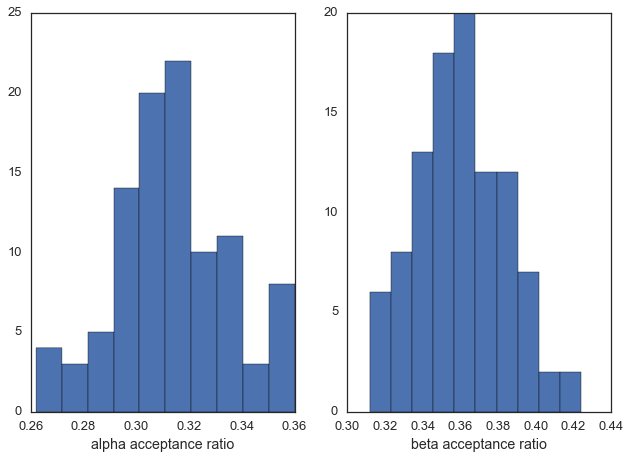

In [23]:
n_iter = 500
acc_ratios = []
for i in range(100):
    start_alpha = np.random.rand(1)*10 - 3
    start_beta = np.random.rand(1)*40 - 10
    trace, acc = metropolis(n_iter, (start_alpha, start_beta), [3.0,12.0], doPrint=False) #3.0, 12.0
    acc_ratios.append(acc/np.double(n_iter))

acc_ratios = np.array(acc_ratios)
plt.subplot(1,2,1)
plt.hist(acc_ratios[:,0])
plt.xlabel("alpha acceptance ratio")
plt.subplot(1,2,2)
plt.hist(acc_ratios[:,1])
plt.xlabel("beta acceptance ratio")

print np.mean(acc_ratios, axis=0)

In [24]:
n_iter = 200000
trace, acc = metropolis(n_iter, (11,17), [3.0,12.0]) #[3.0,12.0])
print acc/np.double(n_iter)

Iterations left:  200000
Iterations left:  190000
Iterations left:  180000
Iterations left:  170000
Iterations left:  160000
Iterations left:  150000
Iterations left:  140000
Iterations left:  130000
Iterations left:  120000
Iterations left:  110000
Iterations left:  100000
Iterations left:  90000
Iterations left:  80000
Iterations left:  70000
Iterations left:  60000
Iterations left:  50000
Iterations left:  40000
Iterations left:  30000
Iterations left:  20000
Iterations left:  10000
[ 0.314505  0.361505]


In [25]:
burnin = 10000    # MY BURN IN 
# throw away the burnin samples
alpha = trace[burnin:,0]; beta=trace[burnin:,1]

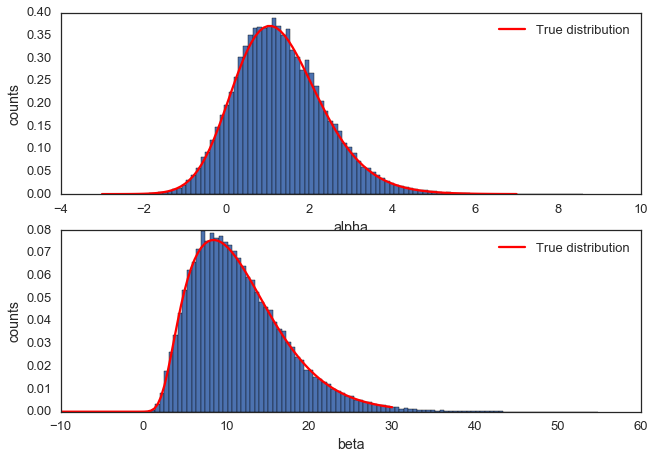

In [26]:
# histogram of alpha
plt.subplot(2,1,1) 
fig=plt.hist(alpha, bins=100, normed=True)
xx= np.linspace(-3,7,101)
pp_a = np.sum(pp, axis=1)
plt.plot(xx, pp_a*6.0, 'r', label=u'True distribution') 
plt.legend()
plt.xlabel("alpha")
plt.ylabel("counts")

# histogram of beta
plt.subplot(2,1,2) 
fig=plt.hist(beta, bins=100, normed=True)
xx = np.linspace(-10, 30,100)
pp_b = np.sum(pp, axis=0)
plt.plot(xx, pp_b*1.5, 'r', label=u'True distribution') 
plt.legend()
plt.xlabel("beta")
plt.ylabel("counts")

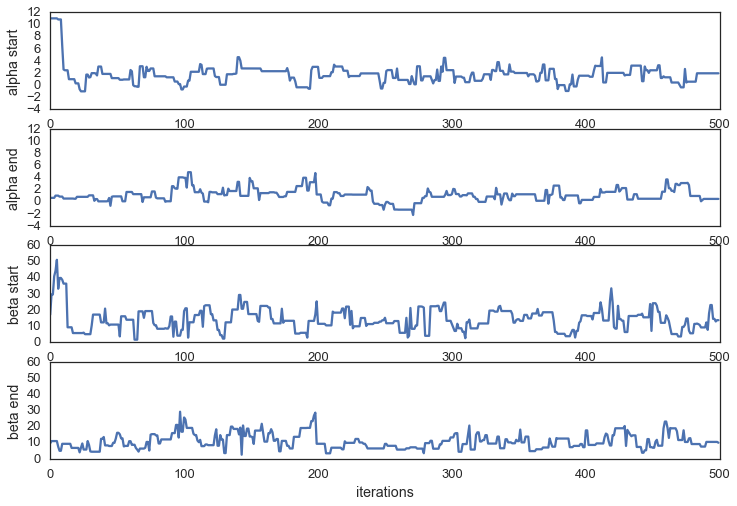

In [27]:
plt.figure(figsize=[12,8])

burnin = 500    # MY BURN IN 
# throw away the burnin samples
alpha = trace[burnin:,0]; beta=trace[burnin:,1]

# trace plot for alpha during burnin
plt.subplot(4,1,1) 
plt.plot(trace[:burnin,0])
plt.ylim(-4,12)
plt.xlabel("iterations")
plt.ylabel("alpha start")

# trace plot for alpha at the end 
# where we hopefully converged
plt.subplot(4,1,2) 
plt.plot(alpha[-burnin:])
plt.ylim(-4,12)
plt.xlabel("iterations")
plt.ylabel("alpha end")

# trace plot for beta during burnin
plt.subplot(4,1,3) 
plt.plot(trace[:burnin,1])
plt.ylim(0,60)
plt.xlabel("iterations")
plt.ylabel("beta start")

# trace plot for beta at the end 
# where we hopefully converged
plt.subplot(4,1,4) 
plt.plot(beta[-burnin:])
plt.ylim(0,60)
plt.xlabel("iterations")
plt.ylabel("beta end")


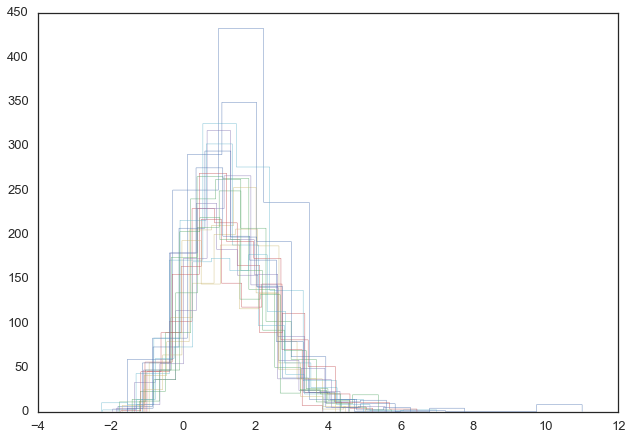

In [28]:
burnin = 1    # MY BURN IN 
# throw away the burnin samples
alpha = trace[burnin:,0]; beta=trace[burnin:,1]

subsetSize = 1000
for i in range(20):
    #plt.hist(alpha[subsetSize*i:subsetSize*(i+1)], alpha=0.4)
    plt.hist(alpha[subsetSize*i:subsetSize*(i+1)], histtype="step")

Let's try to have multiple chains

Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500


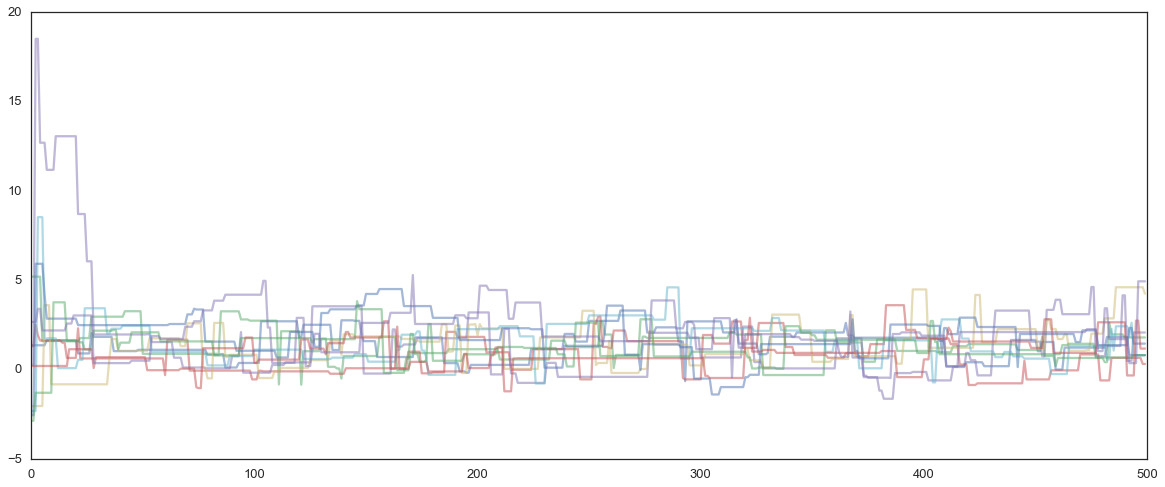

In [78]:
plt.figure(figsize=[20,8])

n_iter = 500
for i in range(10):
    start_alpha = np.random.rand(1)*10 - 3
    start_beta = np.random.rand(1)*40 - 10
    trace, acc = metropolis(n_iter, (start_alpha, start_beta), [10.0,50.0])
    plt.plot(trace[-500:,0], alpha=0.5)

Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500


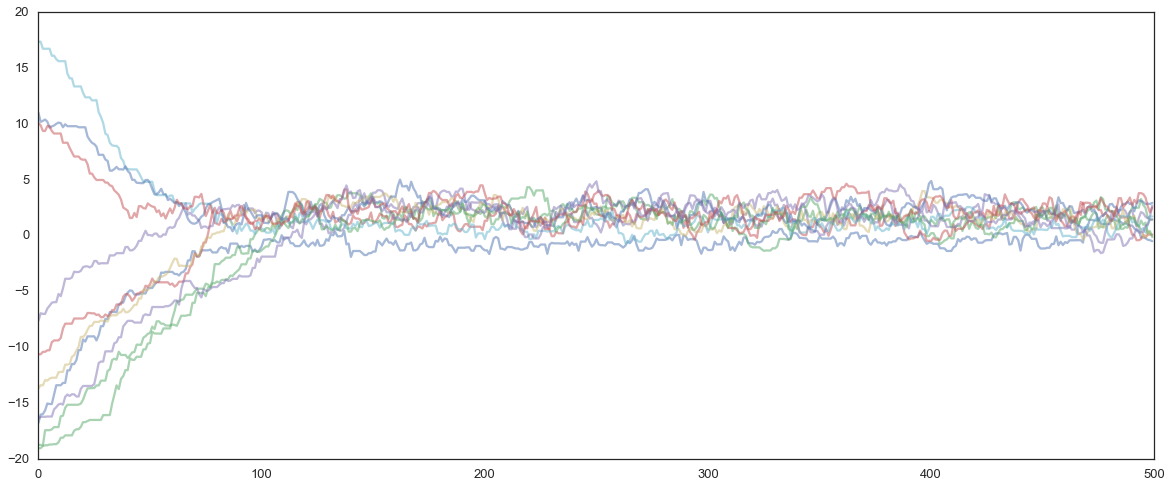

In [79]:
plt.figure(figsize=[20,8])

n_iter = 500
for i in range(10):
    start_alpha = np.random.rand(1)*40 - 20
    start_beta = np.random.rand(1)*40 - 10
    trace, acc = metropolis(n_iter, (start_alpha, start_beta), [0.5,0.05]) #10.0,50.0
    plt.plot(trace[-500:,0], alpha=0.5)